In [119]:
from numpy.random import seed
seed(101)
from tensorflow import set_random_seed
set_random_seed(101)

import pandas as pd
import numpy as np

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import load_img

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


**LABELS**<br>

Excerpts from the paper:<br>
> The HAM10000 Dataset: A Large Collection of Multi-Source Dermatoscopic Images of Common Pigmented Skin Lesions<br>
https://arxiv.org/abs/1803.10417



 **nv**<br>
 Melanocytic nevi<br>
 
 **mel**<br>
 Melanoma<br>
 
 
**bkl**<br>
 Benign keratosis<br>

**bcc**<br>
Basal cell carcinoma<br>
 
**akiec**<br>
Actinic Keratoses (Solar Keratoses) and intraepithelial Carcinoma (Bowen’s disease)<br>


**vasc**<br>
Vascular skin lesions<br>

**df**<br>
Dermatofibroma<br>

**ns**<br>
Normal Skin<br>


In [120]:
os.listdir('../input')

['skin-cancer-mnist-ham10000', 'normal-skins']

### Create the directory structure

In these folders we will store the images that will later be fed to the Keras generators. 

In [121]:


# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 7 folders inside 'base_dir':

# train_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df
    # ns
 
# val_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df
    # ns

# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)
ns = os.path.join(train_dir, 'ns')
os.mkdir(ns)


# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)
ns = os.path.join(val_dir, 'ns')
os.mkdir(ns)



### Create Train and Val Sets

In [122]:
df_data = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### Create a stratified val set

In [123]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [124]:
# identify duplicate images

def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [125]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [126]:
# remove duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

In [127]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=y)

df_val.shape

(1103, 8)

In [128]:
df_val['dx'].value_counts()

nv       883
bkl       88
mel       46
bcc       35
akiec     30
vasc      13
df         8
Name: dx, dtype: int64

### Create a train set that excludes images that are in the val set

In [129]:
# This set will be df_data excluding all rows that are in the val set

def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

8912
1103


In [130]:
df_train['dx'].value_counts()

nv       5822
mel      1067
bkl      1011
bcc       479
akiec     297
vasc      129
df        107
Name: dx, dtype: int64

In [131]:
df_val['dx'].value_counts()

nv       883
bkl       88
mel       46
bcc       35
akiec     30
vasc      13
df         8
Name: dx, dtype: int64

### Transfer the Images into the Folders

In [132]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [133]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('../input/skin-cancer-mnist-ham10000/ham10000_images_part_1')
folder_2 = os.listdir('../input/skin-cancer-mnist-ham10000/ham10000_images_part_2')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

# Transfer the train images

for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../input/skin-cancer-mnist-ham10000/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/skin-cancer-mnist-ham10000/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../input/skin-cancer-mnist-ham10000/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/skin-cancer-mnist-ham10000/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
        

In [134]:
# Add normal skin dataset

# List all image files in the directory
folder_3 = os.listdir('../input/normal-skins/Clean Skin/')

image_dir = '../input/normal-skins/Clean Skin/'

# Create a DataFrame to store filenames and labels
data = []

# Assuming "ns" is the label for normal skin images
label = "ns"

# Iterate through the image files and add them to the DataFrame
for image_filename in folder_3:
    data.append({
        'filename': image_filename,
        'label': label
    })

# Create a DataFrame
df_ns = pd.DataFrame(data)

# Split the dataset into train and validation sets
train_df_ns, val_df_ns = train_test_split(df_ns, test_size=0.2, random_state=42)

# Move images to the train and val directories based on the DataFrame
for index, row in train_df_ns.iterrows():
    # source path to image
    src = os.path.join(image_dir, row['filename'])
    # destination path to image
    dst = os.path.join(train_dir, row['label'], row['filename'])
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

for index, row in val_df_ns.iterrows():
    # source path to image
    src = os.path.join(image_dir, row['filename'])
    # destination path to image
    dst = os.path.join(val_dir, row['label'], row['filename'])
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [135]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))
print(len(os.listdir('base_dir/train_dir/ns')))

5822
1067
1011
479
297
129
107
326


In [136]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))
print(len(os.listdir('base_dir/val_dir/ns')))

883
46
88
35
30
13
8
82


### Copy the train images  into aug_dir

In [137]:
# note that we are not augmenting class 'nv'
class_list = ['mel','bkl','bcc','akiec','vasc','df','ns']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 6000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 1067 images belonging to 1 classes.
Found 1011 images belonging to 1 classes.
Found 479 images belonging to 1 classes.
Found 297 images belonging to 1 classes.
Found 129 images belonging to 1 classes.
Found 107 images belonging to 1 classes.
Found 326 images belonging to 1 classes.


In [138]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))
print(len(os.listdir('base_dir/train_dir/ns')))

5822
5885
5855
5798
5990
5210
4330
5642


In [139]:
# Check how many val images we have in each folder.

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))
print(len(os.listdir('base_dir/val_dir/ns')))

883
46
88
35
30
13
8
82


### Set Up the Generators

In [140]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


In [141]:

datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 44532 images belonging to 8 classes.
Found 1185 images belonging to 8 classes.
Found 1185 images belonging to 8 classes.


### Modify MobileNet Model

In [142]:
# create a copy of a mobilenet model

mobile = tensorflow.keras.applications.mobilenet.MobileNet()

In [143]:
mobile.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [144]:
type(mobile.layers)

list

In [145]:
len(mobile.layers)

93

In [146]:
# CREATE THE MODEL ARCHITECTURE

# Remove the last 5 layers of the model.
x = mobile.layers[-6].output

# Add dense layer for predictions
# 8 number of classes
x = Dropout(0.25)(x)
predictions = Dense(8, activation='softmax')(x)

model = Model(inputs=mobile.input, outputs=predictions)

In [147]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [148]:
# We need to choose how many layers we actually want to be trained.

# Freezing the weights of all layers except the last 23 layers
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

### Train the Model

In [149]:
# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [150]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])


In [151]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'ns': 5, 'nv': 6, 'vasc': 7}


In [152]:
# Add weights to try to make the model more sensitive to melanoma

class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # ns
    6: 1.0, # nv
    7: 1.0, # vasc
}

In [153]:

filepath = "model4.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)


Epoch 1/30
890/892 [============================>.] - ETA: 0s - loss: 1.3207 - categorical_accuracy: 0.5717 - top_2_accuracy: 0.7509 - top_3_accuracy: 0.8579
Epoch 00001: val_categorical_accuracy improved from -inf to 0.74595, saving model to model4.h5
892/892 [==============================] - 68s 77ms/step - loss: 1.3200 - categorical_accuracy: 0.5717 - top_2_accuracy: 0.7510 - top_3_accuracy: 0.8578 - val_loss: 1.0730 - val_categorical_accuracy: 0.7459 - val_top_2_accuracy: 0.8477 - val_top_3_accuracy: 0.8739
Epoch 2/30
891/892 [============================>.] - ETA: 0s - loss: 0.9227 - categorical_accuracy: 0.6617 - top_2_accuracy: 0.8301 - top_3_accuracy: 0.9229
Epoch 00002: val_categorical_accuracy improved from 0.74595 to 0.75586, saving model to model4.h5
892/892 [==============================] - 60s 67ms/step - loss: 0.9222 - categorical_accuracy: 0.6619 - top_2_accuracy: 0.8303 - top_3_accuracy: 0.9230 - val_loss: 1.1027 - val_categorical_accuracy: 0.7559 - val_top_2_accurac

### Evaluate the model using the val set

In [154]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [155]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 0.5871490417544363
val_cat_acc: 0.8213961922030825
val_top_2_acc: 0.914777878513146
val_top_3_acc: 0.9528558476881233


In [156]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 0.5859479028730086
val_cat_acc: 0.8349954669084315
val_top_2_acc: 0.899365367180417
val_top_3_acc: 0.9320036264732547


### Plot the Training Curves

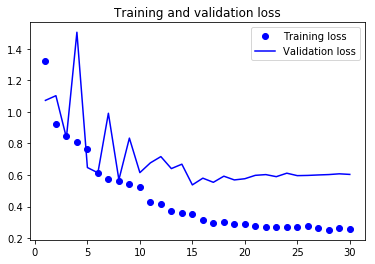

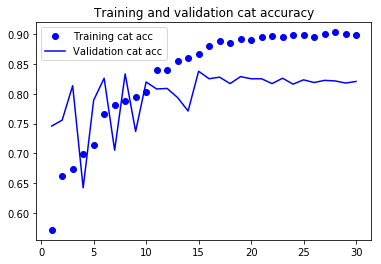

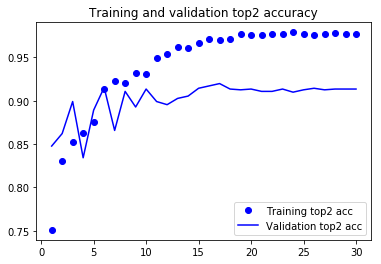

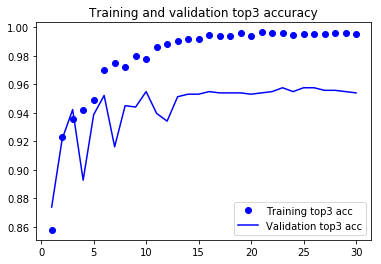

In [157]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

### Create a Confusion Matrix

In [162]:
model_json = model.to_json()
with open('model_architecture.json', 'w') as json_file:
    json_file.write(model_json)

In [163]:
model.save_weights('model_weights2.h5')

In [ ]:
# Delete the image data directory we created to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

shutil.rmtree('base_dir')